![](neuromasts.jpeg)

# Neuromast single cell pipeline 

**Caleb Reagor, Rockefeller University**

Notebook summary:
* Cluster gene trajectories into modules
* Analyze pathway enrichment in pseudotime
* Differential expression analysis of hair cell polarities

In [1]:
# additional dependencies
import h5py, matplotlib, rpy2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# R interface via rpy2
from rpy2 import robjects
import rpy2.robjects.numpy2ri
robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
base = importr("base")
dollar = base.__dict__["$"]


# custom class for sc datasets
# * additional dependencies:
#   * scipy
#   * sklearn
#   * tqdm
#   * scprep
#   * gseapy
#   * magic-impute
#   * bblocks.py

from dataset import dataset

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 1000

from IPython.display import Markdown
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 3)

---
## Load data from Lush et al., 2019

In [3]:
lush = dataset(name='lush et al')

# load GEO dataset from hdf5 file
f = h5py.File(('geo-datasets/'
               'GSE123241.h5'),'r')
    
group = 'danRer10.Ens_84'

lush.raw_counts_from_sparse_matrix(
    
    cell_names = [i.decode('ascii') for i in f[group]['barcodes'][:]],
    gene_names = [i.decode('ascii') for i in f[group]['genes'][:]], 
    data = f[group]['data'], dtype = 'i4', indices = f[group]['indices'],
    indptr = f[group]['indptr'], shape = tuple(reversed(f[group]['shape'])) )

# load pseudotime/clustering from fig 4I
lush4i = pd.read_csv(('geo-datasets/'
                      'lush_fig4i.csv'),
                     index_col=0)

lush4i.sort_values('pseudotime', inplace=True)

display(Markdown('### Raw counts'))
display(lush.raw_counts)

### Raw counts

,ENSDARG00000099104,...,ENSDARG00000101026
AAACCTGAGCACCGCT-1,0,...,0
AAACCTGCACATTCGA-1,3,...,0
AAACCTGCAGGGTTAG-1,1,...,0
AAACCTGCATGCCTTC-1,9,...,0
AAACCTGGTTGAACTC-1,6,...,0
...,...,...,...
TTTGGTTCAGGGAGAG-1,5,...,0
TTTGTCAAGGCGATAC-1,5,...,0
TTTGTCACAGGTGGAT-1,2,...,0
TTTGTCATCGTCACGG-1,11,...,0


In [4]:
# pre-process, scale and impute expression
# * filter rare genes and cells with low counts
# * normalize library sizes, then log scale
# * impute expression using data diffusion

lush.preprocess_raw_counts(library_size_cutoff=0) # pre-filtered

display(Markdown('### Filtered, normalized and scaled counts'))
display(lush.normalized)

### Filtered, normalized and scaled counts

,ENSDARG00000099104,...,ENSDARG00000103244
AAACCTGAGCACCGCT-1,0.000000,...,0.0
AAACCTGCACATTCGA-1,1.159050,...,0.0
AAACCTGCAGGGTTAG-1,0.655604,...,0.0
AAACCTGCATGCCTTC-1,1.435314,...,0.0
AAACCTGGTTGAACTC-1,1.357075,...,0.0
...,...,...,...
TTTGGTTCAGGGAGAG-1,1.360948,...,0.0
TTTGTCAAGGCGATAC-1,1.162867,...,0.0
TTTGTCACAGGTGGAT-1,1.201786,...,0.0
TTTGTCATCGTCACGG-1,1.635424,...,0.0


In [5]:
lush.impute_from_normalized(genes='all_genes')

display(Markdown('### Imputed counts'))
display(lush.imputed)

  Running MAGIC with `solver='exact'` on 14660-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


### Imputed counts

,ENSDARG00000099104,...,ENSDARG00000103244
AAACCTGAGCACCGCT-1,1.190120,...,0.008405
AAACCTGCACATTCGA-1,1.211367,...,0.012077
AAACCTGCAGGGTTAG-1,1.260661,...,0.013888
AAACCTGCATGCCTTC-1,1.277148,...,0.012793
AAACCTGGTTGAACTC-1,1.267471,...,0.012672
...,...,...,...
TTTGGTTCAGGGAGAG-1,1.311220,...,0.011585
TTTGTCAAGGCGATAC-1,1.290064,...,0.012332
TTTGTCACAGGTGGAT-1,1.325106,...,0.011889
TTTGTCATCGTCACGG-1,1.363939,...,0.022344


In [6]:
# new dataset object for differentiating hair cell trajectory
diff_traj = dataset(name='diff hair cell trajectory')

# cell barcodes for cells in the trajectory
trajectory = lush4i.loc[lush4i['cluster'].isin([14,4,2,1])].index

# assign expression values from lush dataset object
diff_traj.raw_counts = lush.raw_counts.loc[trajectory]
diff_traj.normalized = lush.normalized.loc[trajectory]
diff_traj.imputed = lush.imputed.loc[trajectory]

display(Markdown('### Differentiating hair cell trajectory (imputed counts)'))
display(diff_traj.imputed)

### Differentiating hair cell trajectory (imputed counts)

,ENSDARG00000099104,...,ENSDARG00000103244
AAACCTGCAGGGTTAG-1,1.260661,...,0.013888
CAACCTCCAAATACAG-1,1.271162,...,0.013709
GGTGCGTTCCCTCAGT-1,1.253067,...,0.011395
GTCATTTGTAAACACA-1,1.251622,...,0.009966
GTGGGTCCAAGGACAC-1,1.246547,...,0.009423
...,...,...,...
CTGAAACAGATATGGT-1,0.997366,...,0.009640
CTACCCAGTCGTGGCT-1,0.747476,...,0.010875
CACATAGAGGCTAGAC-1,0.773157,...,0.011064
AAGGTTCTCAGCATGT-1,0.755074,...,0.010858


In [7]:
# assign pseudotime/clustering from lush et al figure 4I
diff_traj.pseudotimes = lush4i.loc[trajectory,'pseudotime']
diff_traj.clusters = lush4i.loc[trajectory,'cluster']

display(Markdown('### Trajectory pseudotimes'))
display(diff_traj.pseudotimes)

### Trajectory pseudotimes

AAACCTGCAGGGTTAG-1    0.000000
CAACCTCCAAATACAG-1    0.003734
GGTGCGTTCCCTCAGT-1    0.005161
GTCATTTGTAAACACA-1    0.006055
GTGGGTCCAAGGACAC-1    0.006875
                        ...   
CTGAAACAGATATGGT-1    0.989538
CTACCCAGTCGTGGCT-1    0.992050
CACATAGAGGCTAGAC-1    0.997433
AAGGTTCTCAGCATGT-1    0.997553
TTCTACAAGATCACGG-1    1.000000
Name: pseudotime, Length: 326, dtype: float64

---
## Cluster gene trajectories into modules

In [8]:
# load lateral line genes (lush et al. & zfin)
lat_line = pd.read_csv('refs/drerio_latline.csv')

# bin data along pseudotime and expression axes
# * this spaces the data more evenly (in pseudotime)
# *** via simple histogram binning
# * and allows us to calculate MI (by expression)
# *** via Bayesian blocks adaptive binning 

diff_traj.bin_data(data = 'imputed', in_pt = True, pt_bin = 0.025,
                   genes = lat_line['Ensembl_id'].unique())

display(Markdown('### Bin imputed data in pseudotime and expression'))
display(diff_traj.binned)

### Bin imputed data in pseudotime and expression

,ENSDARG00000001313,...,ENSDARG00000015002
0.0125,1,...,1
0.0375,1,...,1
0.0625,1,...,1
0.0875,1,...,1
0.1125,1,...,1
...,...,...,...
0.8625,0,...,1
0.8875,0,...,1
0.9125,0,...,1
0.9375,0,...,1


In [9]:
# find pairwise gene similarities (adjusted MI)
diff_traj.find_gene_similarities(n_runs=10)

display(Markdown('### Gene similarities (Adjusted Mutual Information)'))
display(diff_traj.gene_similarities)

100%|██████████| 34716/34716 [11:19<00:00, 51.10it/s]


### Gene similarities (Adjusted Mutual Information)

,ENSDARG00000001313,...,ENSDARG00000015002
ENSDARG00000001313,1.000000,...,0.028739
ENSDARG00000001767,0.566515,...,0.014123
ENSDARG00000001785,0.086559,...,0.000412
ENSDARG00000001889,0.119900,...,0.000000
ENSDARG00000002336,0.511548,...,0.083701
...,...,...,...
ENSDARG00000052866,0.040317,...,0.000000
ENSDARG00000057026,0.329717,...,0.172485
ENSDARG00000037238,0.328209,...,0.029594
ENSDARG00000014259,0.054012,...,0.019160


### Find the optimal number of clusters using spectral clustering and silhouette score

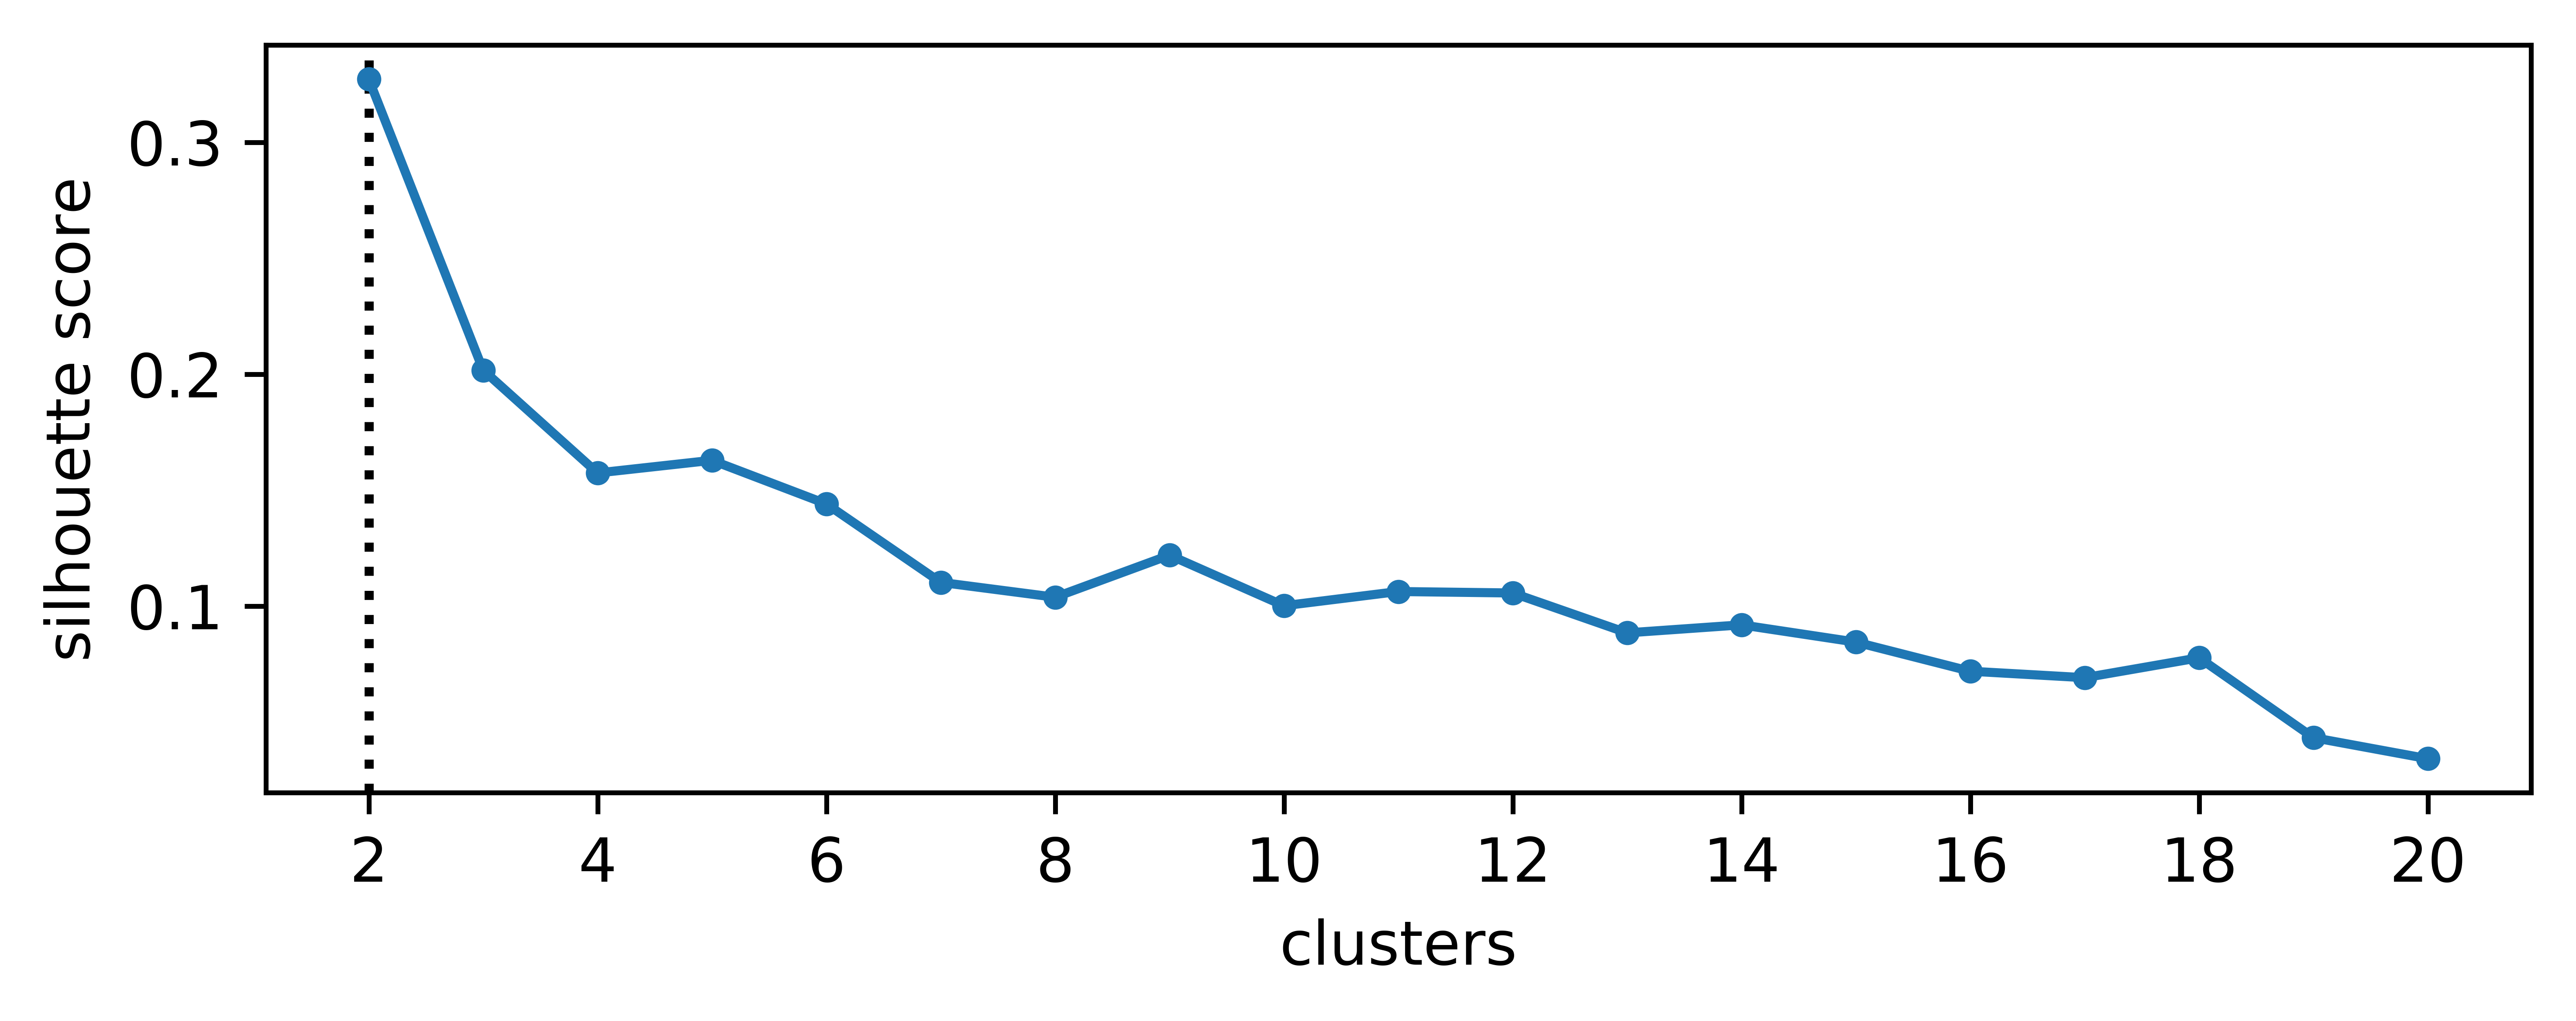

In [10]:
diff_traj.cluster_genes(n_components=2, max_clusters=20, plot_silhouette=True)

### Plot average gene module trajectories and errors

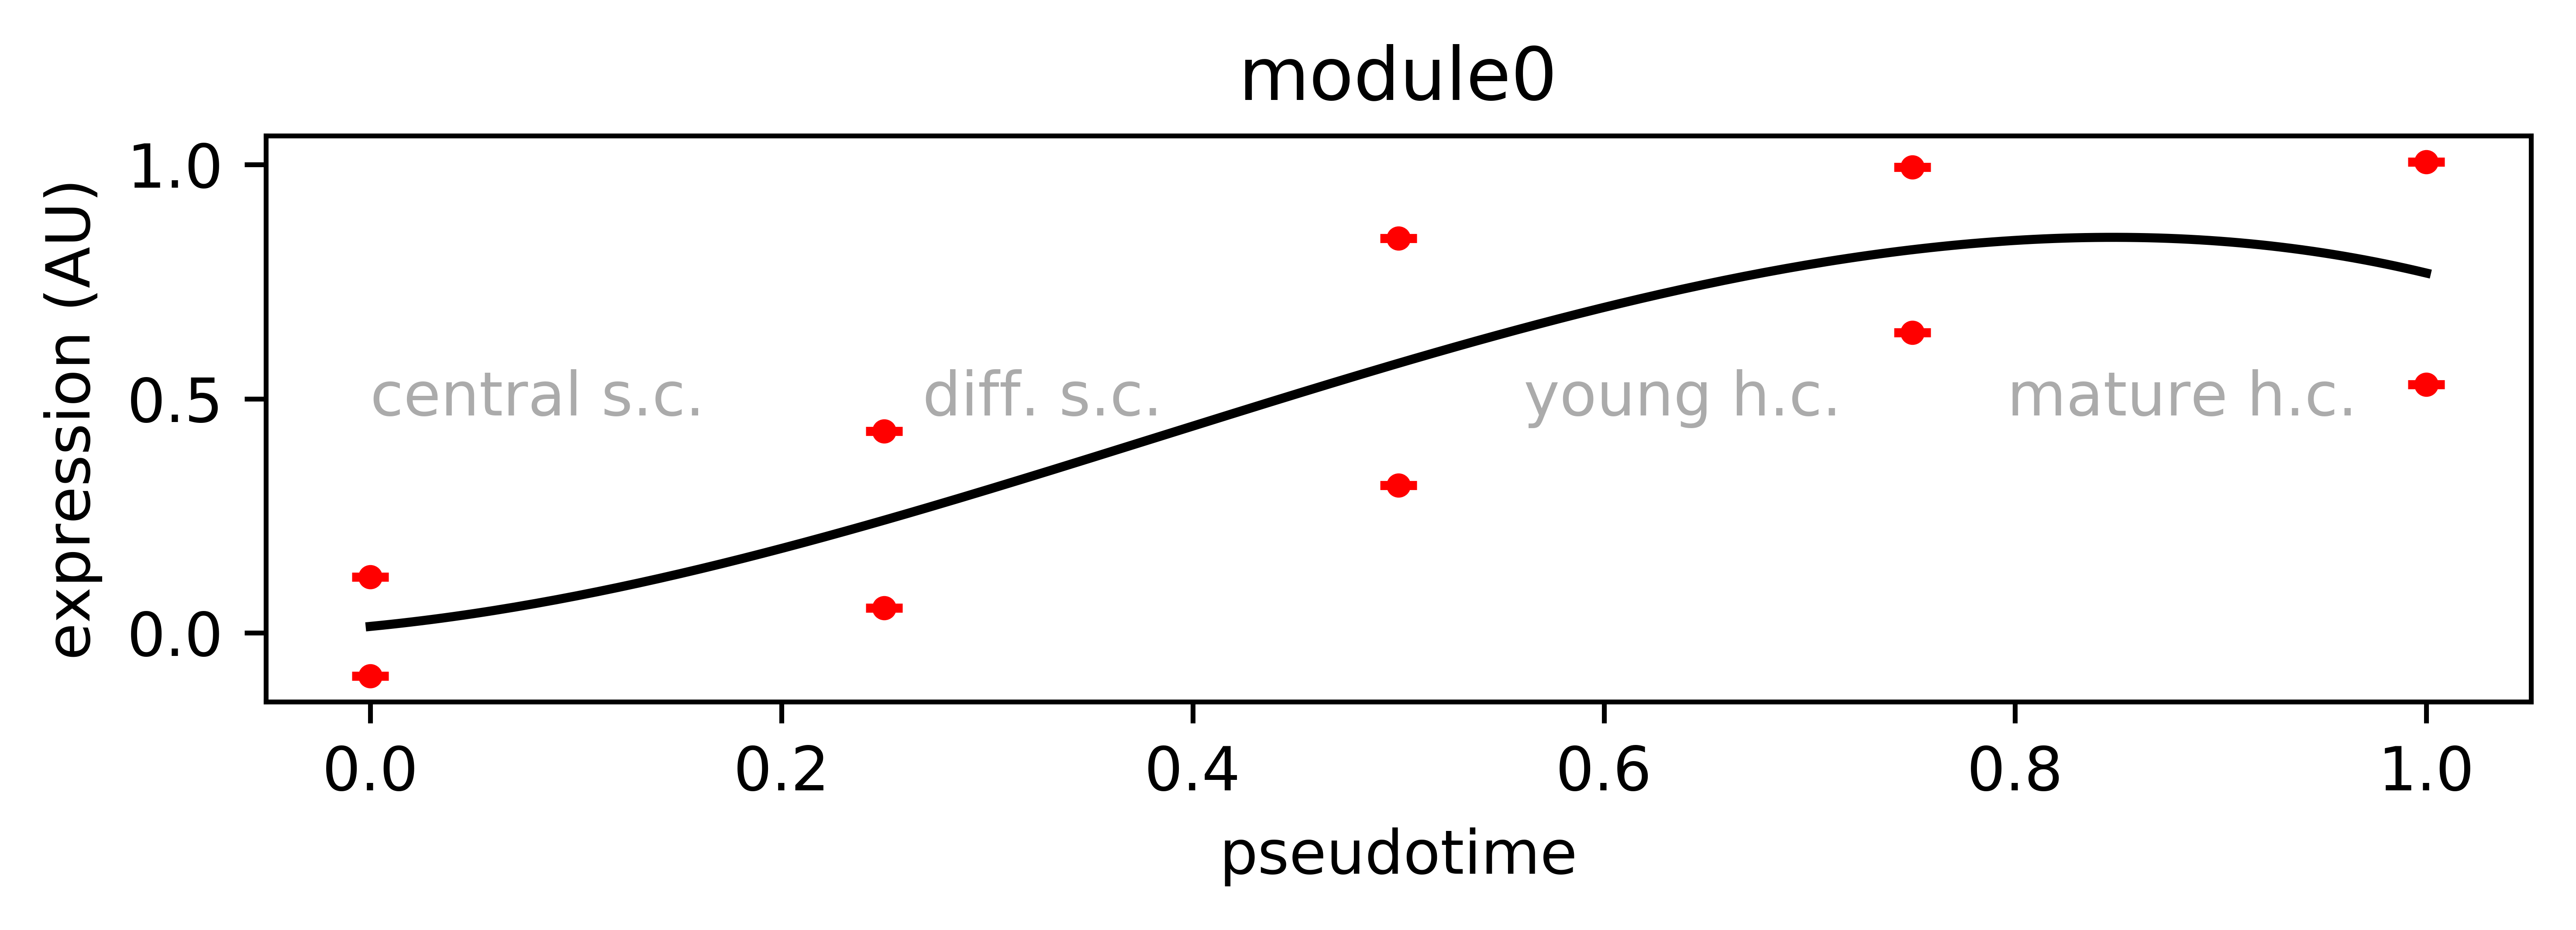

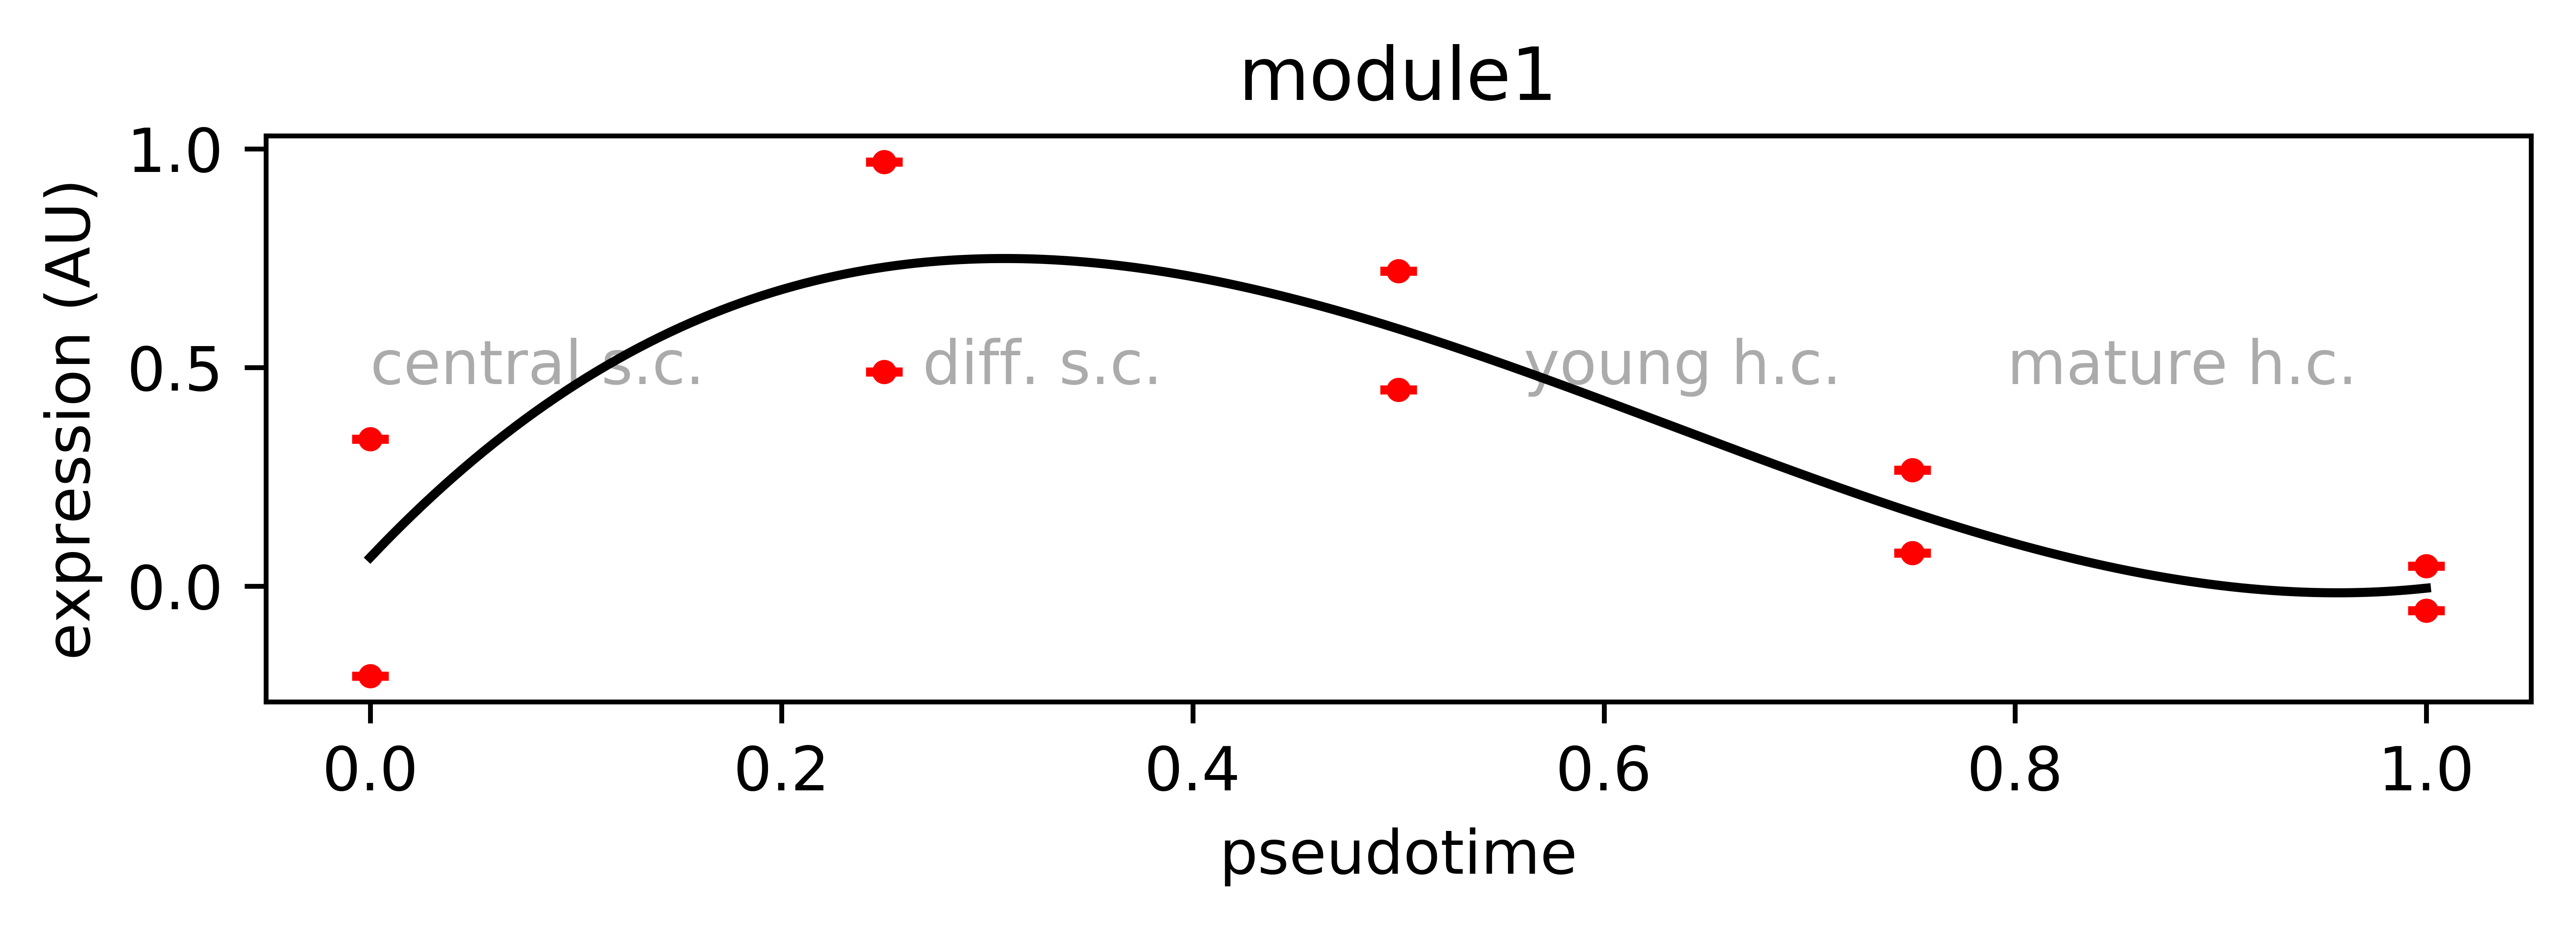

In [11]:
# plot smoothened average and errors for each module
diff_traj.plot_modules(data='imputed', smoothing=0.1)

# add labels for cell stage
for ax in diff_traj.module_axes:
    y, a, z, v = 0.5, 0.33, 0, 'center'
    ax.text(diff_traj.pseudotimes.iloc[np.where(diff_traj.clusters==14)].min(),
            y, 'central s.c.', va=v, ha='left', alpha=a, zorder=z)
    ax.text(diff_traj.pseudotimes.iloc[np.where(diff_traj.clusters==4)].max(),
            y, 'diff. s.c.', va=v, ha='left', alpha=a, zorder=z)
    ax.text(diff_traj.pseudotimes.iloc[np.where(diff_traj.clusters==2)].mean(),
            y, 'young h.c.', va=v, ha='center', alpha=a, zorder=z)
    ax.text(diff_traj.pseudotimes.iloc[np.where(diff_traj.clusters==1)].mean(),
            y, 'mature h.c.', va=v, ha='center', alpha=a, zorder=z)

---
## Cell signaling pathway enrichment in pseudotime

In [12]:
# order genes along pseudotime axis
# * criteria: maximum expression pseudotime

diff_traj.order_genes_pt(method='max')

display(Markdown('### Maximum expression'))
display(diff_traj.genes_1d)

### Maximum expression

,pt
ENSDARG00000001313,0.399935
ENSDARG00000001767,0.399935
ENSDARG00000001785,0.629324
ENSDARG00000001889,0.629324
ENSDARG00000002336,0.422220
...,...
ENSDARG00000052866,0.482444
ENSDARG00000057026,0.422220
ENSDARG00000037238,0.934950
ENSDARG00000014259,0.425101


In [ ]:
# bin genes in pseudotime and perform GO analysis
# * term enrichment for KEGG pathways via Enrichr

display(Markdown('### GO term enrichment for developmental cell signaling pathways'))

diff_traj.pathway_ea_in_pt(pathways = ['Cell cycle',
                           'Notch signaling pathway',
                           'Wnt signaling pathway',
                           'Hedgehog signaling pathway',
                           'TGF-beta signaling pathway'],
                            pt_bin=0.09999, plot=True)

### GO term enrichment for developmental cell signaling pathways

 90%|█████████ | 9/10 [00:27<00:03,  3.56s/it]

---
## Find differentially expressed genes between hair cells of opposite polarities

In [ ]:
# # new dataset object for polarizing hair cells
# pols = dataset(name='polarizing hair cells')

# # cell barcodes for differentiating central support cells
# cells = lush4i.loc[lush4i['cluster'].isin([14,4])].index

# # assign data from previous trajectory dataset object
# pols.raw_counts = diff_traj.raw_counts.loc[cells]
# pols.normalized = diff_traj.normalized.loc[cells]
# pols.imputed = diff_traj.imputed.loc[cells]
# pols.pseudotimes = diff_traj.pseudotimes[cells]
# pols.clusters = diff_traj.clusters[cells]

# display(Markdown('### Hair cells undergoing the polarity determination (imputed counts)'))
# display(pols.imputed)

### Embed cells in low dimensions using known polarity genes

In [ ]:
# # load polarity genes: deltas, notch genes, emx2
# pol_genes = pd.read_csv('refs/polarity_genes.csv')
# pol_genes.set_index('Ensembl_id', drop=False, inplace=True)
# g = pol_genes['Ensembl_id'].isin(pols.imputed.columns).index
# g_names = pol_genes.loc[g]
# g_names.drop('Ensembl_id', axis=1, inplace=True)

# # dimensionality reduction
# pols.embed_pca(data='imputed', 
#                n_components=5, 
#                genes=g)

# # t-stochastic neighbor embedding
# pols.embed_tsne(data='pca')

# display(Markdown('### Polarity genes'))
# display(g_names)

### Fit a principal curve to the differentiating hair cell trajectory

In [ ]:
# # use the princurve package in R
# princurve = importr('princurve', on_conflict='warn')
# pc = princurve.principal_curve(pols.tsne_embedding.values)
# cur = np.array(dollar(pc,'s'))
# ordr = np.array(dollar(pc,'ord')) - 1

# pol_point = -35 # polarization point
# tsne1_pre = cur[ordr,0][:pol_point+1]
# tsne2_pre = cur[ordr,1][:pol_point+1]
# tsne1_pol = cur[ordr,0][pol_point:]
# tsne2_pol = cur[ordr,1][pol_point:]

# # new cluster labels for hair cells split by principal curve
# new_labels = pols.tsne_embedding.iloc[ordr,1][pol_point:] > tsne2_pol
# pols.clusters.loc[new_labels.index] = new_labels.astype(np.int)

In [ ]:
# # plot the polarity tsne and principal curve
# pols.plot_embedding(data='tsne', ar=0.6, 
#                     labels=['central s.c.', 
#                             'diff s.c.', 
#                             'polarity0',
#                             'polarity1'])

# pols.embedding_axes.plot(tsne1_pol, 
#                          tsne2_pol, 
#                          c='gray')

# pols.embedding_axes.plot(tsne1_pre, 
#                          tsne2_pre,
#                          linestyle='--', 
#                          c='gray')
# display(Markdown('### A principal curve separates differentiating hair cells of opposite polarities'))
# display(Markdown('* tSNE embedding based only on genes known to participate in the polarity determination'))
# plt.show()

### Test for differential gene expression between cells of opposite polarities

In [ ]:
# # deseq2 diff expression analysis
# pols.diff_exp2(clusters=[0,1])

### Plot expression of known polarity genes

In [ ]:
# pols.plot_violin(clusters=[0,1], cluster_labels=['polarity0', 'polarity1'],
#                  gene=g_names.index[5], gene_label=g_names['gene_name'].values[5], ar=1)

In [ ]:
# pols.plot_violin(clusters=[0,1], cluster_labels=['polarity0', 'polarity1'],
#                  gene='ENSDARG00000054562', gene_label='her15.1', ar=0.2)